In [13]:
from math import sqrt

import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import skimage
from skimage import io, exposure, img_as_float, img_as_ubyte, morphology, filters, util
from skimage.color import rgb2gray, label2rgb
from skimage.feature import canny, blob_dog, blob_log, blob_doh,  peak_local_max
from skimage.filters import sobel, threshold_otsu, try_all_threshold, threshold_local, threshold_minimum
from skimage.segmentation import clear_border, watershed, random_walker
from skimage.measure import label, regionprops
from skimage.measure import label, regionprops
from skimage.color import label2rgb
from skimage.morphology import closing
from skimage.io import imsave, imread

import cv2

from scipy import ndimage as ndi
from scipy.stats import norm
from scipy import stats

import os
import math

import plotly.graph_objs as go

import platform

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

from skimage.morphology  import remove_small_objects
from skimage import color
from PIL import Image

from matplotlib.colors import hsv_to_rgb

flags = [i for i in dir(cv2) if i.startswith('COLOR_')]

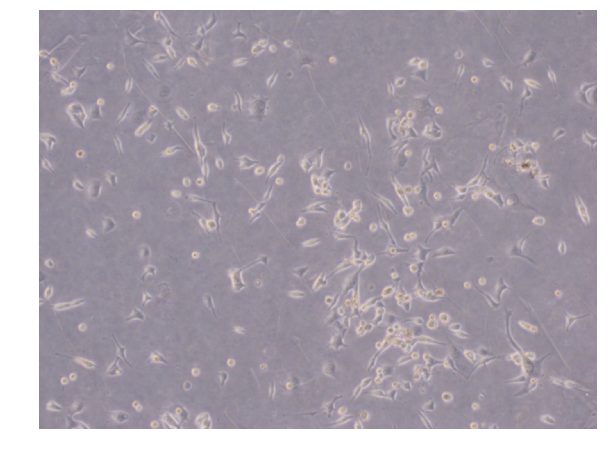

In [14]:
image = cv2.imread('/Users/carolinemccue/Dropbox (MIT)/Project_ReversibleCellAdhesion_Broad/Shear Experiments/Newcells_100822/AllImages/Flat_0.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.GaussianBlur(image,(13,13),0)
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image)
plt.show()

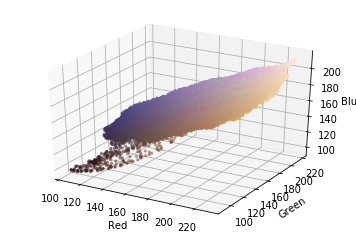

In [15]:
r, g, b = cv2.split(image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection='3d')

pixel_colors = image.reshape((np.shape(image)[0]*np.shape(image)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

In [16]:
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

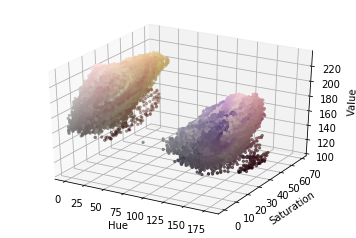

In [17]:
h, s, v = cv2.split(hsv_image)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection='3d')

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

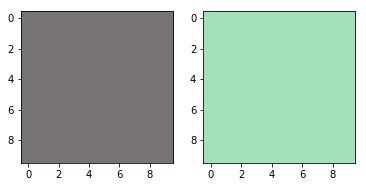

In [18]:
colormin = (0, 10, 120)
colormax = (100, 70, 225)

min_square = np.full((10, 10, 3), colormin, dtype=np.uint8) / 255.0
max_square = np.full((10, 10, 3), colormax, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(min_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(max_square))
plt.show()

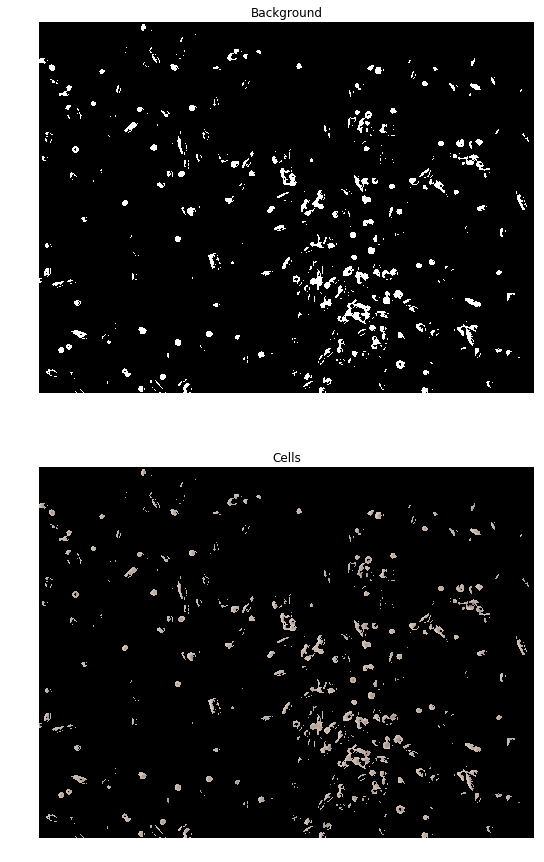

In [19]:
mask = cv2.inRange(hsv_image, colormin, colormax)
result = cv2.bitwise_and(image, image, mask=mask)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
ax = axes.ravel()

ax[0].imshow(mask, cmap="gray")
ax[0].set_title('Background')
ax[1].imshow(result)
ax[1].set_title('Cells')

for a in ax:
    a.set_axis_off()
plt.show()

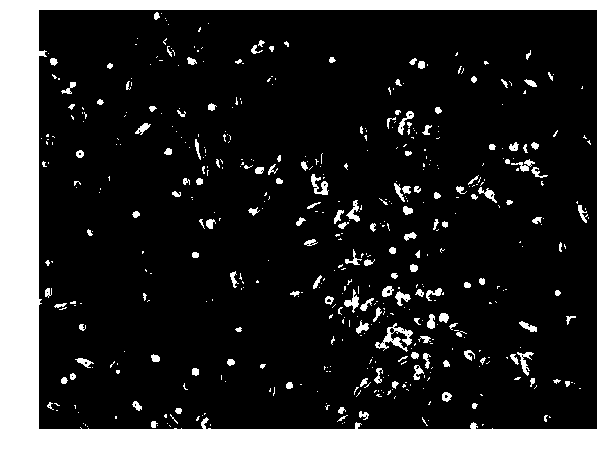

In [20]:
rgbresult = cv2.cvtColor(result, cv2.COLOR_HSV2RGB)
resultgray = color.rgb2gray(rgbresult)

retVal, resultbw = cv2.threshold(resultgray, 0, 120, cv2.THRESH_BINARY)
resultbw = resultbw.astype(np.uint8)

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(resultbw, cmap='gray')
plt.show()

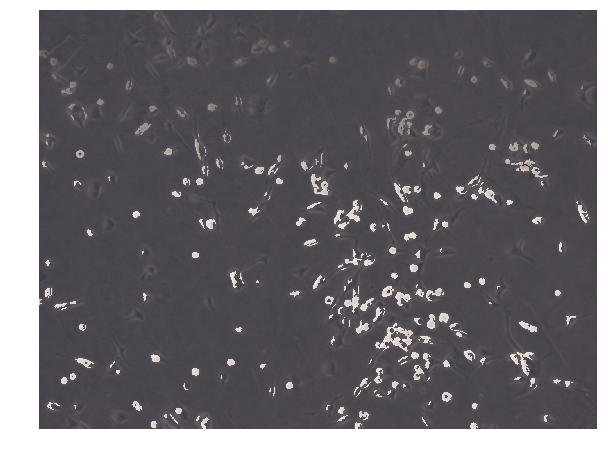

In [21]:
noise = skimage.measure.label(resultbw)
removeposts = morphology.remove_small_objects(noise, min_size=50)
#removeposts = removeposts.astype(np.uint8)

fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(image)
plt.imshow(removeposts, cmap = 'gray', vmin=0, vmax=255, interpolation='nearest', alpha = 0.5)
plt.show()

In [22]:
cellarea = np.sum(removeposts > 0)
background = np.sum(removeposts == 0)
cellpercent = cellarea / (cellarea + background)
print(cellpercent)

0.03627278645833333


In [23]:
images_path = '/Users/carolinemccue/Dropbox (MIT)/Project_ReversibleCellAdhesion_Broad/Shear Experiments/Newcells_100822/AllImages'

cellarea_list = []
time_list = []
surf_list = []


for image_file in os.listdir(images_path):

    input_path = os.path.join(images_path, image_file)
    frame = cv2.imread(input_path)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
    frame = cv2.GaussianBlur(frame,(13,13),0)
    
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_frame, colormin, colormax)
    result = cv2.bitwise_and(frame, frame, mask=mask)

    resultgray = color.rgb2gray(result)

    retVal, resultbw = cv2.threshold(resultgray, 0, 120, cv2.THRESH_BINARY)
    resultbw = resultbw.astype(np.uint8)

    noise = skimage.measure.label(resultbw)
    removeposts = morphology.remove_small_objects(noise, min_size=100)
    removeposts = removeposts.astype(np.uint8)

    cellarea = np.sum(removeposts > 0)
    background = np.sum(removeposts == 0)
    cellpercent = cellarea / (cellarea + background)
    
    cellarea_list.append(cellpercent)
    time = int((image_file.split('_')[1]).split('.')[0])
    time_list.append(time)
    
    surf = str((image_file.split('_')[0]))
    surf_list.append(surf)
    

error: OpenCV(4.5.5) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
df = pd.DataFrame()
df['Time'] = time_list
df['Area'] = cellarea_list
df['Surface'] = surf_list
df = df.sort_values(by=['Time'], ascending=True)
df = df.sort_values(by=['Surface'], ascending=True)

df['Area_Normalized'] = df['Area'] / np.roll(df['Area'], shift=-1)

df = df[df['Area_Normalized'] <= 1]

df

In [ ]:
x = df['Surface']
y = df['Area']

fig, ax = plt.subplots()
ax.bar(x, y, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Area of cell coverage Removed (%)')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlabel('Post Diameter ($\mu m$)')
ax.set_title('30 Pa')

plt.tight_layout()
plt.show()

In [ ]:
#df.to_excel('/Users/carolinemccue/Dropbox (MIT)/Project_ReversibleCellAdhesion_Broad/Shear Experiments/Image Processing/ShearForceResults_flat.xlsx')